the design of a neural network that can discover binding motifs in DNA based on the results of an assay that determines whether a longer DNA sequence binds to the protein or not. Here, the longer DNA sequences are our independent variables (or predictors), while the positive or negative response of the assay is the dependent variable (or response).

We will use simulated data that consists of DNA sequences of length 50 bases (chosen to be artificially short so that the data is easy to play around with), and is labeled with 0 or 1 depending on the result of the assay. Our goal is to build a classifier that can predict whether a particular sequence will bind to the protein and discover the short motif that is the binding site in the sequences that are bound to the protein.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, LSTM, Embedding, Lambda
from tensorflow.keras.models import Model, Sequential
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import requests

In [ ]:
# Load DNA sequences
SEQUENCES_URL = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/sequences.txt'
sequences = requests.get(SEQUENCES_URL).text.split('\n')
sequences = list(filter(None, sequences))

pd.DataFrame(sequences, index=np.arange(1, len(sequences)+1),
             columns=['Sequences']).head()

,Sequences
1,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...
2,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...
3,GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...
4,GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...
5,GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...


In [ ]:
# Encode DNA sequences as one-hot vectors
label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(categories='auto')
input_features = []

for sequence in sequences:
    integer_encoded = label_encoder.fit_transform(list(sequence))
    integer_encoded = np.array(integer_encoded).reshape(-1, 1)
    one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
    input_features.append(one_hot_encoded.toarray())

input_features = np.stack(input_features)
input_features.shape

(2000, 50, 4)

In [ ]:
np.set_printoptions(threshold=40)
input_features = np.stack(input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)

Example sequence
-----------------------
DNA Sequence #1:
 CCGAGGGCTA ... CGCGGACACC
One hot encoding of Sequence #1:
 [[0. 0. 0. ... 1. 0. 0.]
 [1. 1. 0. ... 0. 1. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
# Load labels
LABELS_URL = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/labels.txt'
labels = requests.get(LABELS_URL).text.split('\n')
labels = list(filter(None, labels))

labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()
print('Labels:\n',labels.T)
print('One-hot encoded labels:\n',input_labels.T)

Labels:
 [['0' '0' '0' ... '0' '1' '1']]
One-hot encoded labels:
 [[1. 1. 1. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]]


In [ ]:
# Split into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, input_labels, test_size=0.25, random_state=42)

# VAE for DNA sequence generation
latent_dim = 16  # Dimensionality of the latent space
input_shape = train_features.shape[1:]  # Shape of the input DNA sequences

In [ ]:
# Encoder
inputs = Input(shape=input_shape)
x = Conv1D(filters=32, kernel_size=12, activation='relu', padding='same')(inputs)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

In [ ]:
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

In [ ]:
# Decoder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(64, activation='relu')(latent_inputs)
x = Dense(np.prod(input_shape), activation='relu')(x)
x = tf.keras.layers.Reshape(input_shape)(x)
x = Conv1D(filters=32, kernel_size=12, activation='relu', padding='same')(x)
outputs = Dense(4, activation='softmax')(x)

In [ ]:
# Define VAE model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
decoder = Model(latent_inputs, outputs, name='decoder')
vae_outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, vae_outputs, name='vae')

In [ ]:
# Loss function
vae.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=['binary_accuracy'])
vae.summary()


Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 50, 4)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Functional)                 │ [(None, 16), (None, 16),    │          54,912 │
│                                      │ (None, 16)]                 │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 50, 4)               │          15,788 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 70,700 (276.17 KB)

 Trainable params: 70,700 (276.17 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train VAE
vae.fit(train_features, train_features, epochs=50, batch_size=32, validation_split=0.2)

# Generate new sequences
def generate_sequences(num_sequences=10):
    latent_samples = np.random.normal(size=(num_sequences, latent_dim))
    generated_sequences = decoder.predict(latent_samples)
    return generated_sequences

new_sequences = generate_sequences(10)
print("Generated DNA Sequences (One-hot encoded):")
print(new_sequences)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - binary_accuracy: 0.7425 - loss: 0.6496 - val_binary_accuracy: 0.7500 - val_loss: 0.5671
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - binary_accuracy: 0.7500 - loss: 0.5655 - val_binary_accuracy: 0.7500 - val_loss: 0.5636
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - binary_accuracy: 0.7500 - loss: 0.5627 - val_binary_accuracy: 0.7500 - val_loss: 0.5628
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - binary_accuracy: 0.7500 - loss: 0.5616 - val_binary_accuracy: 0.7500 - val_loss: 0.5623
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - binary_accuracy: 0.7500 - loss: 0.5612 - val_binary_accuracy: 0.7500 - val_loss: 0.5615
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - binary_accuracy: 0.7500 - loss: 0.5603 - val_binary_accuracy: 0.7500 - val_loss: 0.5597
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - binary_accuracy: 0.7500 - loss: 0.5579 - val_binary_accuracy: 0.7502 - val_loss: 0.5553
Epoch 8/50
38/38

In [ ]:
# Convert numerical sequence back to DNA sequence (A=0, T=1, C=2, G=3)
def decode_sequence(sequence):
    mapping = {0: 'A', 1: 'T', 2: 'C', 3: 'G'}
    # Convert one-hot encoded sequence to integer sequence
    integer_sequence = np.argmax(sequence, axis=1) # Get the index of the maximum value along axis 1 (columns)
    return ''.join([mapping[n] for n in integer_sequence]) # Now use integer_sequence for lookup

decoded_sequences = [decode_sequence(seq) for seq in new_sequences]

print("Generated DNA Sequences:")
for seq in decoded_sequences:
    print(seq)

Generated DNA Sequences:
CCAACTTTCATTCTTTGATCATTGTTTTTTTTCTTTTTTTTTTTTTTTTT
CCATCATTCATTTTATGATTCAATGTTTTTATTTTTTCATTCAATGTTTT
TTTATTTCATCATTCAATGCTTTTTTTTTTCATTCTTTTTTCAACCTTTT
TCAATTTAATGCTTCAATGCATTTTTTTTTTTATTTTATTTTATGTTTTG
TCTCCTTTTATTTTAATGTAACTCAATTTTTTTTTAATTTAATTTTTTGT
GAATAATTTTTTTTCTCATTTTTCATTCATTTTTATTGATTTTCATGTTT
TCAATTCATTTATTATCATCAATGTTTTTTATTCATCATTCATTGTTCAT
CCATCATTCATTTTTTTCTATGATCCTCGTTCATGTAAGGTTATCAAACG
CTATCATTGTCATTCAATCATCCATCAATTTTTTTTACTCATTTTATTGT
TCATTCTATTCATTCAATGTCATGTTTTTTGTTTCAATGTTAACGCAACT


In [ ]:
# Property prediction model
property_model = Sequential([
    Conv1D(filters=32, kernel_size=12, activation='relu', input_shape=(train_features.shape[1], 4)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(16, activation='relu'),
    Dense(2, activation='softmax')
])

property_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
property_model.fit(train_features, train_labels, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5238 - loss: 0.6919 - val_accuracy: 0.6733 - val_loss: 0.6383
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7372 - loss: 0.5976 - val_accuracy: 0.7900 - val_loss: 0.4833
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8119 - loss: 0.4547 - val_accuracy: 0.7933 - val_loss: 0.4548
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8492 - loss: 0.3779 - val_accuracy: 0.8300 - val_loss: 0.3374
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8681 - loss: 0.3212 - val_accuracy: 0.8900 - val_loss: 0.2645
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9320 - loss: 0.2270 - val_accuracy: 0.9367 - val_loss: 0.2120
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9692 - loss: 0.1664 - val_accuracy: 0.9633 - val_loss: 0.1676
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9790 - loss: 0.1303 - val_accuracy: 0.9733 - val_loss: 0.1362
Ep

In [ ]:
# Evaluate new sequences
property_predictions = property_model.predict(new_sequences)
print("Predicted Properties for Generated Sequences:")
print(property_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Predicted Properties for Generated Sequences:
[[0.0540618  0.9459381 ]
 [0.00251766 0.9974823 ]
 [0.04134851 0.95865154]
 [0.5014621  0.49853793]
 [0.3806813  0.61931866]
 [0.00173129 0.9982688 ]
 [0.02803659 0.97196335]
 [0.02479507 0.975205  ]
 [0.31029692 0.68970305]
 [0.00493971 0.99506027]]


In [ ]:
# VAE Metrics
vae_loss, vae_accuracy = vae.evaluate(train_features, train_features, verbose=0)  # Evaluate on training data
print(f"VAE Training Loss: {vae_loss:.4f}")
print(f"VAE Training Accuracy: {vae_accuracy:.4f}")


vae_loss, vae_accuracy = vae.evaluate(test_features, test_features, verbose=0)  # Evaluate on test data
print(f"VAE Test Loss: {vae_loss:.4f}")
print(f"VAE Test Accuracy: {vae_accuracy:.4f}")


# Property Prediction Model Metrics
property_loss, property_accuracy = property_model.evaluate(train_features, train_labels, verbose=0)  # Evaluate on training data
print(f"Property Model Training Loss: {property_loss:.4f}")
print(f"Property Model Training Accuracy: {property_accuracy:.4f}")

property_loss, property_accuracy = property_model.evaluate(test_features, test_labels, verbose=0)  # Evaluate on test data
print(f"Property Model Test Loss: {property_loss:.4f}")
print(f"Property Model Test Accuracy: {property_accuracy:.4f}")

# Additional metrics (example)

# For the VAE, you could calculate the reconstruction error on the test set.
# For the property prediction model, you might want to calculate precision, recall,
# F1-score, AUC-ROC, etc., depending on your specific task.


# Example: Reconstruction Error
reconstructed_sequences = vae.predict(test_features)
reconstruction_error = np.mean(np.square(test_features - reconstructed_sequences))
print(f"VAE Reconstruction Error (MSE): {reconstruction_error:.4f}")

VAE Training Loss: 0.4315
VAE Training Accuracy: 0.8015
VAE Test Loss: 0.4671
VAE Test Accuracy: 0.7844
Property Model Training Loss: 0.0103
Property Model Training Accuracy: 0.9973
Property Model Test Loss: 0.0313
Property Model Test Accuracy: 0.9900
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
VAE Reconstruction Error (MSE): 0.1579


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


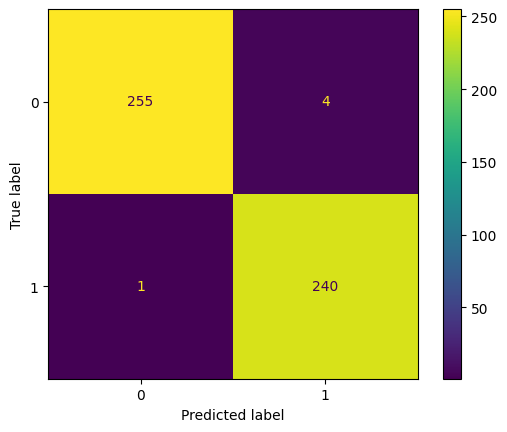

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming you have your true labels (y_true) and predicted labels (y_pred)
# Replace these with your actual data
y_true = np.argmax(test_labels, axis=1)  # Convert one-hot encoded labels to class labels
y_pred = np.argmax(property_model.predict(test_features), axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()